<a href="https://colab.research.google.com/github/jhordi19/Ciencia_de_datos/blob/Taller/Taller_Sem09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Valoración de Riesgo de Hipertensión Modelo ML**

El dataset fue sacado de Kaggle el cual tiene el nombre de
[Hypertension Risk Prediction Dataset](https://www.kaggle.com/datasets/ankushpanday1/hypertension-risk-prediction-dataset/datahttps://)

✅ Instalación de Librerías Necesarias

In [ ]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 4.7 MB/s eta 0:00:00


📚 Importar Librerías autilizar

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from scipy.stats import randint,  uniform
from imblearn.combine import SMOTEENN
from sklearn.compose import ColumnTransformer

--------------------------------------------------------------------------

##🧩 1. Cargamos el Dataset

In [ ]:
df = pd.read_csv("hypertension_dataset.csv")

Identificamos la dimension del dataset

In [ ]:
df.shape

(174982, 23)

Seleccionamos las Columnas a utilizar

In [ ]:
cols = ['Gender', 'Age', 'BMI', 'Physical_Activity_Level', 'Sleep_Duration',
        'Smoking_Status', 'Salt_Intake', 'Alcohol_Intake', 'Family_History',
        'Stress_Level', 'Hypertension']
df = df[cols].copy()

--------------------------------------------------------------------------

##🧪 2. Preprocesamiento de Datos

Se codifican las variables categóricas y se escalan los datos numéricos.

In [ ]:
df['Hypertension'] = df['Hypertension'].map({'High': 1, 'Low': 0})

# 3. Mapear binarios
df['Family_History'] = df['Family_History'].map({'No': 0, 'Yes': 1})

# 4. Discretizar
def bin_alcohol(x):
    if x == 0:
        return 'None'
    elif x <= 10:
        return 'Low'
    elif x <= 20:
        return 'Moderate'
    else:
        return 'High'

def bin_salt(x):
    if x < 5:
        return 'Low'
    elif x <= 10:
        return 'Moderate'
    else:
        return 'High'

df['Alcohol_Level'] = df['Alcohol_Intake'].apply(bin_alcohol)
df['Salt_Level'] = df['Salt_Intake'].apply(bin_salt)

# 5. Definir X e y
X = df.drop(['Hypertension', 'Alcohol_Intake', 'Salt_Intake'], axis=1)
y = df['Hypertension']

# 6. Columnas por tipo
numeric_cols = ['Age', 'BMI', 'Sleep_Duration']
ordinal_cols = ['Smoking_Status', 'Physical_Activity_Level', 'Stress_Level', 'Alcohol_Level', 'Salt_Level']
ordinal_map = [
    ['Never', 'Former', 'Current'],
    ['Low', 'Moderate', 'High'],
    list(range(1, 11)),
    ['None', 'Low', 'Moderate', 'High'],
    ['Low', 'Moderate', 'High']
]
binary_cols = ['Family_History']
nominal_cols = ['Gender']

# 7. Preprocesamiento
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('ord', OrdinalEncoder(categories=ordinal_map), ordinal_cols),
    ('bin', 'passthrough', binary_cols),
    ('nom', OneHotEncoder(drop='first'), nominal_cols)
])

# 8. Aplicar preprocesamiento
X_preprocessed = preprocessor.fit_transform(X)

Verificamos el tipo de dato

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174982 entries, 0 to 174981
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Gender                   174982 non-null  object 
 1   Age                      174982 non-null  int64  
 2   BMI                      174982 non-null  float64
 3   Physical_Activity_Level  174982 non-null  object 
 4   Sleep_Duration           174982 non-null  float64
 5   Smoking_Status           174982 non-null  object 
 6   Salt_Intake              174982 non-null  float64
 7   Alcohol_Intake           174982 non-null  float64
 8   Family_History           174982 non-null  int64  
 9   Stress_Level             174982 non-null  int64  
 10  Hypertension             174982 non-null  int64  
 11  Alcohol_Level            174982 non-null  object 
 12  Salt_Level               174982 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 17.4+ MB


Verificamos si tiene nulos

In [ ]:
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
Gender                     0
Age                        0
BMI                        0
Physical_Activity_Level    0
Sleep_Duration             0
Smoking_Status             0
Salt_Intake                0
Alcohol_Intake             0
Family_History             0
Stress_Level               0
Hypertension               0
Alcohol_Level              0
Salt_Level                 0
dtype: int64


--------------------------------------------------------------------------

## ⚖️ 3. Balanceo con SMOTE

Aplicamos SMOTE para poder balancear las clases minoritarias.

In [ ]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_preprocessed, y)

## 🤖 4. Entrenamiento de Modelos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

##4.1 AdaBoost

In [ ]:
# === Entrenamiento con AdaBoost ===
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Árbol más profundo como base
base_tree = DecisionTreeClassifier()

adaboost_model = AdaBoostClassifier(
    estimator=base_tree,
    random_state=42
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

grid = GridSearchCV(
    AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42),
    param_grid,
    cv=10,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("Mejores parámetros:", grid.best_params_)


adaboost_model.fit(X_train, y_train)
y_pred = adaboost_model.predict(X_test)

# Predicción
y_pred_ada = adaboost_model.predict(X_test)

# Evaluación
print("=== MATRIZ DE CONFUSIÓN ===")
print(confusion_matrix(y_test, y_pred_ada))

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred_ada))

print("\n=== EXACTITUD ===")
print("Accuracy:", accuracy_score(y_test, y_pred_ada))

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Mejores parámetros: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}
=== MATRIZ DE CONFUSIÓN ===
[[11305  2630]
 [ 2990  5763]]

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     13935
           1       0.69      0.66      0.67      8753

    accuracy                           0.75     22688
   macro avg       0.74      0.73      0.74     22688
weighted avg       0.75      0.75      0.75     22688


=== EXACTITUD ===
Accuracy: 0.7522919605077574


In [ ]:
from sklearn.pipeline import Pipeline
import joblib

# Paso 1: Crear el pipeline usando el preprocesador y el modelo ya entrenado
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', adaboost_model)  # este ya está entrenado
])

# Paso 2: Guardar el pipeline
joblib.dump(final_pipeline, 'Adaboost.pkl')
print("✅ Modelo exportado correctamente")

✅ Modelo exportado correctamente


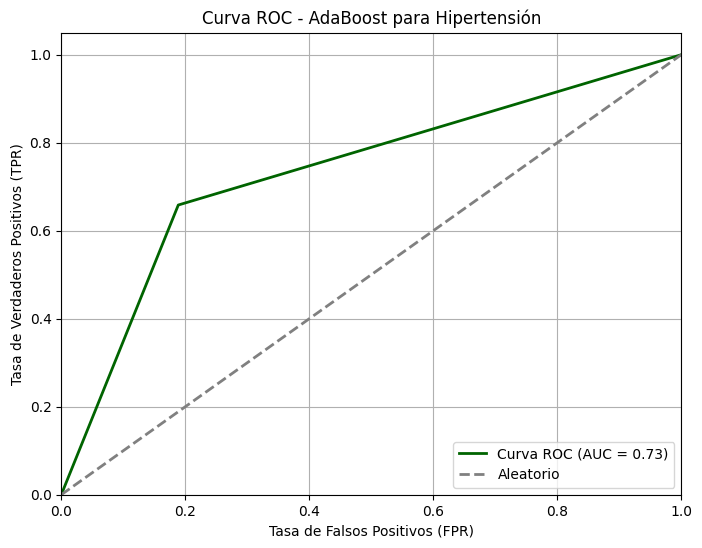

In [ ]:
# ROC Curve
y_proba_ada = adaboost_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_ada)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - AdaBoost para Hipertensión')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 🚀 4.2. CatBoost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [300, 500, 700],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128]
}

cat = CatBoostClassifier(eval_metric='F1', verbose=0, random_seed=42)

search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist,
    scoring='f1',
    cv=10,
    n_iter=10,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("✅ Mejores parámetros:", search.best_params_)
best_cat = search.best_estimator_


Fitting 10 folds for each of 10 candidates, totalling 100 fits
✅ Mejores parámetros: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 10, 'border_count': 128}


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Definir y entrenar el modelo
cat_model = CatBoostClassifier(
    learning_rate=0.1,
    l2_leaf_reg=1,
    iterations=300,
    depth=10,
    border_count=128,
    eval_metric='F1',
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train)

# Predicciones
y_pred_cat = cat_model.predict(X_test)
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# Evaluación
print("=== MATRIZ DE CONFUSIÓN ===")
print(confusion_matrix(y_test, y_pred_cat))

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred_cat))

print("\n=== EXACTITUD ===")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))

0:	learn: 0.1777638	total: 25.3ms	remaining: 7.57s
100:	learn: 0.8056103	total: 2.39s	remaining: 4.71s
200:	learn: 0.8315958	total: 4.77s	remaining: 2.35s
299:	learn: 0.8563443	total: 7.19s	remaining: 0us
=== MATRIZ DE CONFUSIÓN ===
[[10363  3572]
 [  413  8340]]

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     13935
           1       0.70      0.95      0.81      8753

    accuracy                           0.82     22688
   macro avg       0.83      0.85      0.82     22688
weighted avg       0.86      0.82      0.83     22688


=== EXACTITUD ===
Accuracy: 0.8243564880112835


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

y_proba_best = cat_model.predict_proba(X_test)[:, 1]
y_pred_catbest = (y_proba_best >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred_catbest))
print(classification_report(y_test, y_pred_catbest))
print("Accuracy:", accuracy_score(y_test, y_pred_catbest))
print("F1-score:", f1_score(y_test, y_pred_catbest))


[[10363  3572]
 [  413  8340]]
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     13935
           1       0.70      0.95      0.81      8753

    accuracy                           0.82     22688
   macro avg       0.83      0.85      0.82     22688
weighted avg       0.86      0.82      0.83     22688

Accuracy: 0.8243564880112835
F1-score: 0.8071618678925719


In [ ]:
from sklearn.pipeline import Pipeline
import joblib

# Crear pipeline completo
final_pipeline_catboost = Pipeline([
    ('preprocessor', preprocessor),   # Usa el preprocesador ya entrenado
    ('classifier', cat_model)         # Usa el modelo ya entrenado
])

# Exportar como archivo .pkl
joblib.dump(final_pipeline_catboost, 'CatBoost.pkl')
print("✅ Modelo CatBoost exportado correctamente")


✅ Modelo CatBoost exportado correctamente


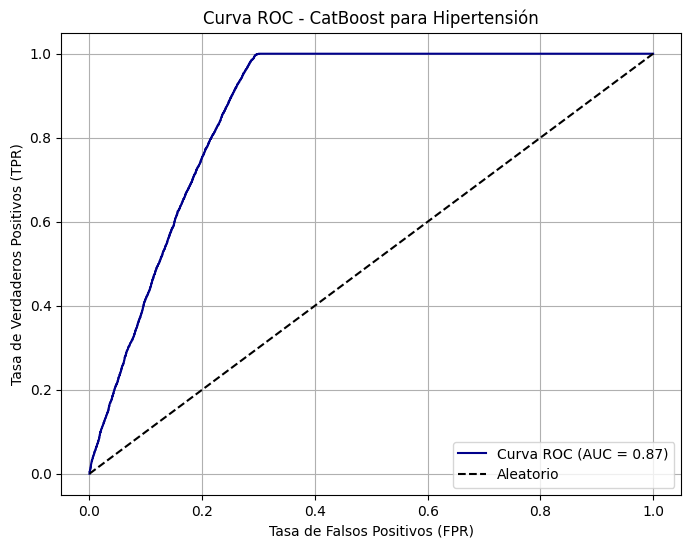

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='darkblue')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - CatBoost para Hipertensión')
plt.legend()
plt.grid(True)
plt.show()

## 🚀 4.3. LightGBM

In [ ]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.6 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 500],
    'num_leaves': [31, 63, 127],
    'max_depth': [5, 7, 9],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

lgbm = LGBMClassifier(random_state=42)

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    scoring='f1',
    cv=10,
    n_iter=10,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_lgbm = search.best_estimator_
print("✅ Mejores parámetros:", search.best_params_)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 35011, number of negative: 55740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 90751, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.385792 -> initscore=-0.465036
[LightGBM] [Info] Start training from score -0.465036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [ ]:
# === ENTRENAMIENTO CON LIGHTGBM ===
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np

# Entrenar modelo con los mejores hiperparámetros
model_lgb = LGBMClassifier(
    learning_rate=0.1,
    n_estimators=500,
    num_leaves=63,
    max_depth=5,
    min_child_samples=100,
    subsample=0.6,
    colsample_bytree=1.0,
    reg_alpha=0,
    reg_lambda=0,
    random_state=42
)

model_lgb.fit(X_train, y_train)

# Obtener probabilidades para el conjunto de prueba
y_pred_lgb = model_lgb.predict(X_test)

# Evaluación
print("=== MATRIZ DE CONFUSIÓN ===")
print(confusion_matrix(y_test, y_pred_lgb))

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred_lgb))

print("\n=== EXACTITUD ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 35011, number of negative: 55740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 90751, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.385792 -> initscore=-0.465036
[LightGBM] [Info] Start training from score -0.465036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

y_proba_best = model_lgb.predict_proba(X_test)[:, 1]
y_pred_lgbmbest = (y_proba_best >= 0.6).astype(int)

print(confusion_matrix(y_test, y_pred_lgbmbest))
print(classification_report(y_test, y_pred_lgbmbest))
print("Accuracy:", accuracy_score(y_test, y_pred_lgbmbest))
print("F1-score:", f1_score(y_test, y_pred_lgbmbest))


[[10904  3031]
 [ 1788  6965]]
              precision    recall  f1-score   support

           0       0.86      0.78      0.82     13935
           1       0.70      0.80      0.74      8753

    accuracy                           0.79     22688
   macro avg       0.78      0.79      0.78     22688
weighted avg       0.80      0.79      0.79     22688

Accuracy: 0.7875969675599436
F1-score: 0.7429729585577898


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.pipeline import Pipeline
import joblib

# Crear pipeline completo con el preprocesador y el modelo entrenado
final_pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model_lgb)  # Ya está entrenado
])

# Exportar el pipeline a un archivo .pkl
joblib.dump(final_pipeline_lgbm, 'LightGBM.pkl')
print("✅ Modelo LightGBM exportado correctamente")


✅ Modelo LightGBM exportado correctamente


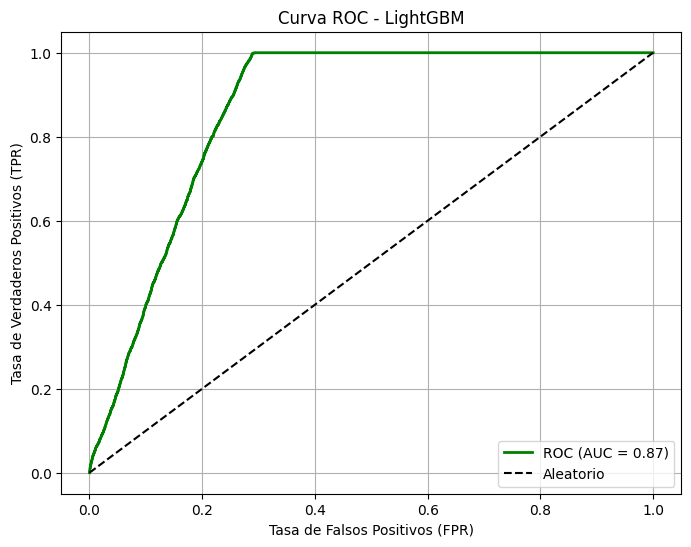

In [ ]:
# === CURVA ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - LightGBM')
plt.legend()
plt.grid(True)
plt.show()

## 📊 5. Comparación de Modelos desarrollados

Finalmente realizamos un gráfico comparando las métricas de los modelos desarrollados observando:
- Accuracy
- Precision
- Recall
- F1-Score

📊 Métricas comparadas:


,Accuracy,Precision,Recall,F1-Score
AdaBoost,0.752292,0.750639,0.752292,0.751271
CatBoost,0.824356,0.860772,0.824356,0.826555
LightGBM,0.787597,0.796491,0.787597,0.789680


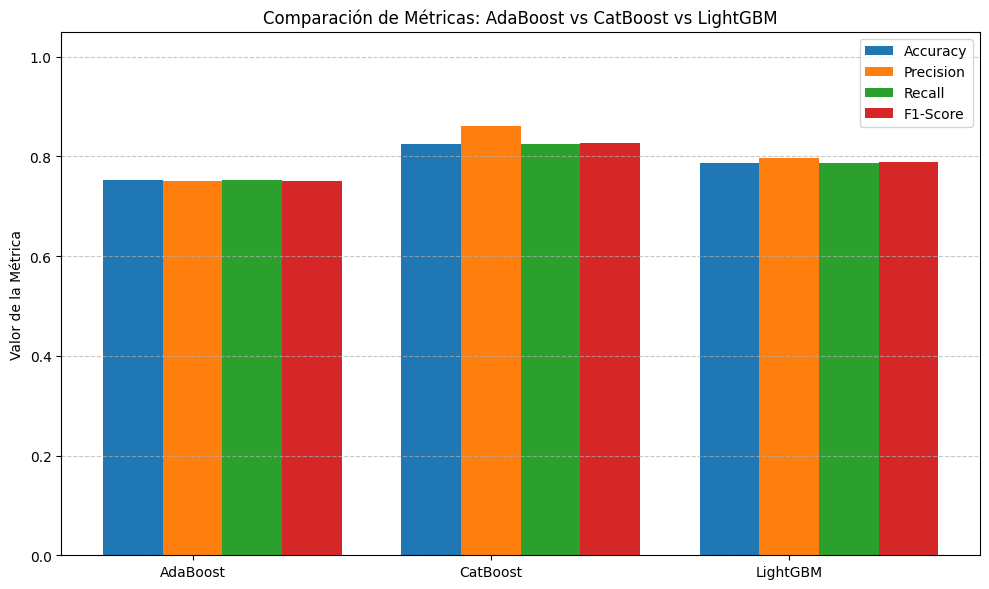

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calcular métricas
metricas = {
    "AdaBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_ada),
        "Precision": precision_score(y_test, y_pred_ada, average='weighted'),
        "Recall": recall_score(y_test, y_pred_ada, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred_ada, average='weighted')
    },
    "CatBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_catbest),
        "Precision": precision_score(y_test, y_pred_catbest, average='weighted'),
        "Recall": recall_score(y_test, y_pred_catbest, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred_catbest, average='weighted')
    },
    "LightGBM": {
        "Accuracy": accuracy_score(y_test, y_pred_lgbmbest),
        "Precision": precision_score(y_test, y_pred_lgbmbest, average='weighted'),
        "Recall": recall_score(y_test, y_pred_lgbmbest, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred_lgbmbest, average='weighted')
    }
}

# Crear DataFrame
df_metricas = pd.DataFrame(metricas).T

# Mostrar las métricas
print("📊 Métricas comparadas:")
display(df_metricas)

# Crear gráfico de barras agrupadas
labels = df_metricas.index
metricas_names = df_metricas.columns
x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(10, 6))
for i, metrica in enumerate(metricas_names):
    plt.bar(x + i * width, df_metricas[metrica], width=width, label=metrica)

plt.xticks(x + width, labels)
plt.ylim(0, 1.05)
plt.ylabel("Valor de la Métrica")
plt.title("Comparación de Métricas: AdaBoost vs CatBoost vs LightGBM")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
